# Import des outils / jeu de données

In [1]:
import statistics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prince
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import bartlett, shapiro
from statsmodels.formula.api import ols

In [2]:
np.random.seed(0)
sns.set_theme()

In [3]:
df = pd.read_csv(
    "data/data-cleaned-feature-engineering.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

In [4]:
df_transforme = pd.read_csv(
    "data/data-transformed.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

## Variables globales

In [5]:
var_numeriques = [
    "Year_Birth",
    "Income",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

In [6]:
var_categoriques = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
]

# ANOVA

## Problématique

Nous allons tester l'indépendance entre la variable `NumStorePurchaes` (catégorique, désignant le nombre d'achat en magasin sur un mois pour un client donné) et `Income` (quantitative continue).  
Nous souhaitons répondre à la question : "le revenu influence-t-il effectivement la propension d'un client à acheter plus dans notre magasin ?"

Les boites à moustaches superposées ci-dessous nous donne l'intuition que la réponse est OUI.  
Nous allons le vérifier par une `ANOVA`.

<Axes: xlabel='NumStorePurchases', ylabel='Income'>

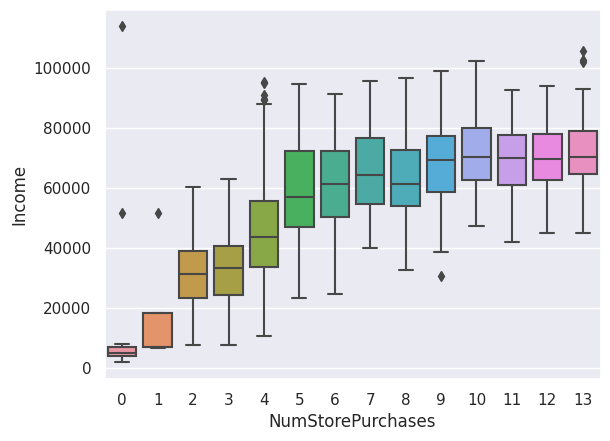

In [7]:
sns.boxplot(df, x="NumStorePurchases", y="Income")

On cherche à déterminer si les moyennes des groupes sont significativement différentes.  
L'ANOVA fait le rapport des variances interclasse et intraclasse.

#### Somme des Carrés des Ecarts (SCE) interclasse

$$ SCEinterclasse = \sum\limits_{k=1}^{N}(\bar{Y_k}\ - \bar{Y})^2 * u_k $$

où $ \bar{Y_k} $ est la valeur de la moyenne du groupe k, $ \bar{Y} $ est la moyenne de la population totale et $ u_k $ est le poids du groupe k et N est le nombre de groupe.

#### SCE intraclasse

$$ SCEintraclasse = \sum\limits_{k=1}^{N} \sum\limits_{i=1}^{n_k} (X_i^k - \bar{Y_k})^2 $$

où $n_k$ est le nombre d'individus dans le groupe k
  
On a alors $ SCEtotale = SCEintraclasse + SCEinterclasse $

On pose donc :

$H_0$ : Les moyennes de chaque groupe sont égales si la p-value $> 5\%$
$H_1$ : Les moyennes de chaque groupe ne sont pas toutes égales si la p-value $< 5\%$

## Hypothèses à vérifier

1) la variable d'intérêt est qualitative, la variable explicative est quantitative
1) l’indépendance entre les échantillons de chaque groupe
2) l’égalité des variances entre les groupes (homoscédasticité)
3) la normalité des résidus avec un test de Shapiro.

### Indépendance

L'indépendance se vérifie en pratique dans la façon dont sont mesurées les données. Ici nos clients ne se connaissent pas, ne sont pas liés entre eux, et agissent indépendemment les uns des autres.

### Egalité des variances

In [8]:
df.groupby("NumStorePurchases")["Income"].std()

NumStorePurchases
0     34607.120012
1     22417.953411
2     10718.068057
3     11458.886120
4     17429.474234
5     16341.587418
6     14435.950632
7     13435.506705
8     13383.964093
9     12497.483886
10    11037.158885
11    11282.717409
12    10943.183482
13    11594.032675
Name: Income, dtype: float64

Nous allons effectuer un test de Levene pour vérifier l'égalité statistique des variances.

$H_0$ : Les variances de chaque groupe sont égales si p-value $> 5\%$
$H_1$ : Les variances de chaque groupe ne sont pas toutes égales $< 5\%$


In [9]:
group_by = [
    df[df["NumStorePurchases"] == i]["Income"]
    for i in range(max(df["NumStorePurchases"]) + 1)
]

In [10]:
stats.levene(
    group_by[0],
    group_by[1],
    group_by[2],
    group_by[3],
    group_by[4],
    group_by[5],
    group_by[6],
    group_by[7],
    group_by[8],
    group_by[9],
    group_by[10],
    group_by[11],
    group_by[12],
    group_by[13],
)

LeveneResult(statistic=8.660739674776176, pvalue=1.976572083996012e-17)

Notre p-value est largement inférieure à 5%, donc les variances ne sont pas toutes égales.  
Nous allons voir ce problème de plus près.

In [11]:
%%capture

group_std = pd.DataFrame(columns=["std"])

for i in range(len(group_by)):
    group_std = group_std.append(
        pd.DataFrame({"std": [statistics.stdev(group_by[i])]}, index=[i])
    )

Text(0.5, 1.0, "Ecart type des revenus en fonction du nombre d'achat en magasin")

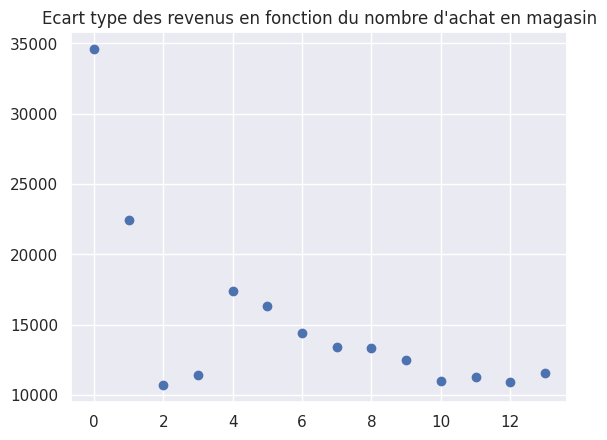

In [12]:
plt.plot(group_std, "bo")
plt.title("Ecart type des revenus en fonction du nombre d'achat en magasin")

On constate que les variances sont en effet dispersées, notamment à cause des groupes aux nombres d'achats 0 et 1.  
Vérifions que la taille de chacun des groupes est suffisamment grande pour être significatif.  

In [13]:
for i in range(len(group_by)):
    print(len(group_by[i]))

print(
    "Les groupes aux nombres d'achats 0 et 1 sont trop petits pour être significatifs, on les retire de l'analyse."
)

11
4
206
447
295
197
161
132
136
99
118
71
93
75
Les groupes aux nombres d'achats 0 et 1 sont trop petits pour être significatifs, on les retire de l'analyse.


In [14]:
del group_by[0:2]
group_std = group_std.drop(labels=[0, 1], axis="index")

Text(0.5, 1.0, "Ecart type des revenus en fonction du nombre d'achats - données nettoyées")

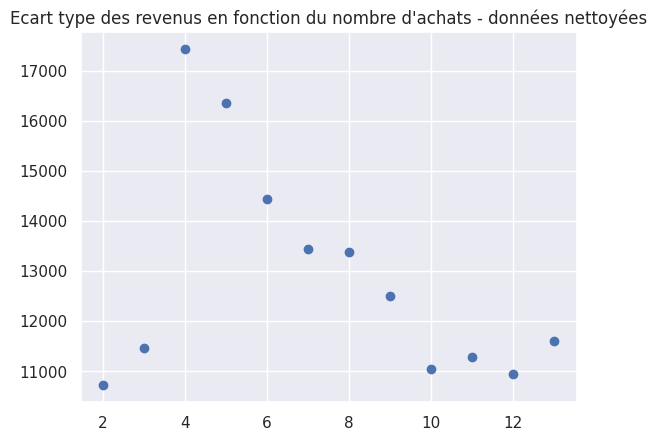

In [15]:
plt.plot(group_std, "bo")
plt.title("Ecart type des revenus en fonction du nombre d'achats - données nettoyées")

On créer un dataframe pour l'ANOVA où l'on conserve uniquement les données qui nous intéressent.

In [16]:
df_anova = df[df["NumStorePurchases"] > 1][["NumStorePurchases", "Income"]]
print(df_anova)

       NumStorePurchases   Income
ID                               
5524                   4  58138.0
2174                   2  46344.0
4141                  10  71613.0
6182                   4  26646.0
5324                   6  58293.0
...                  ...      ...
8080                   3  26816.0
10870                  4  61223.0
7270                  13  56981.0
8235                  10  69245.0
9405                   4  52869.0

[2030 rows x 2 columns]


### Normalité des distributions des groupes

In [17]:
group_by_reshape = np.reshape(group_by, (3, 4))

/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


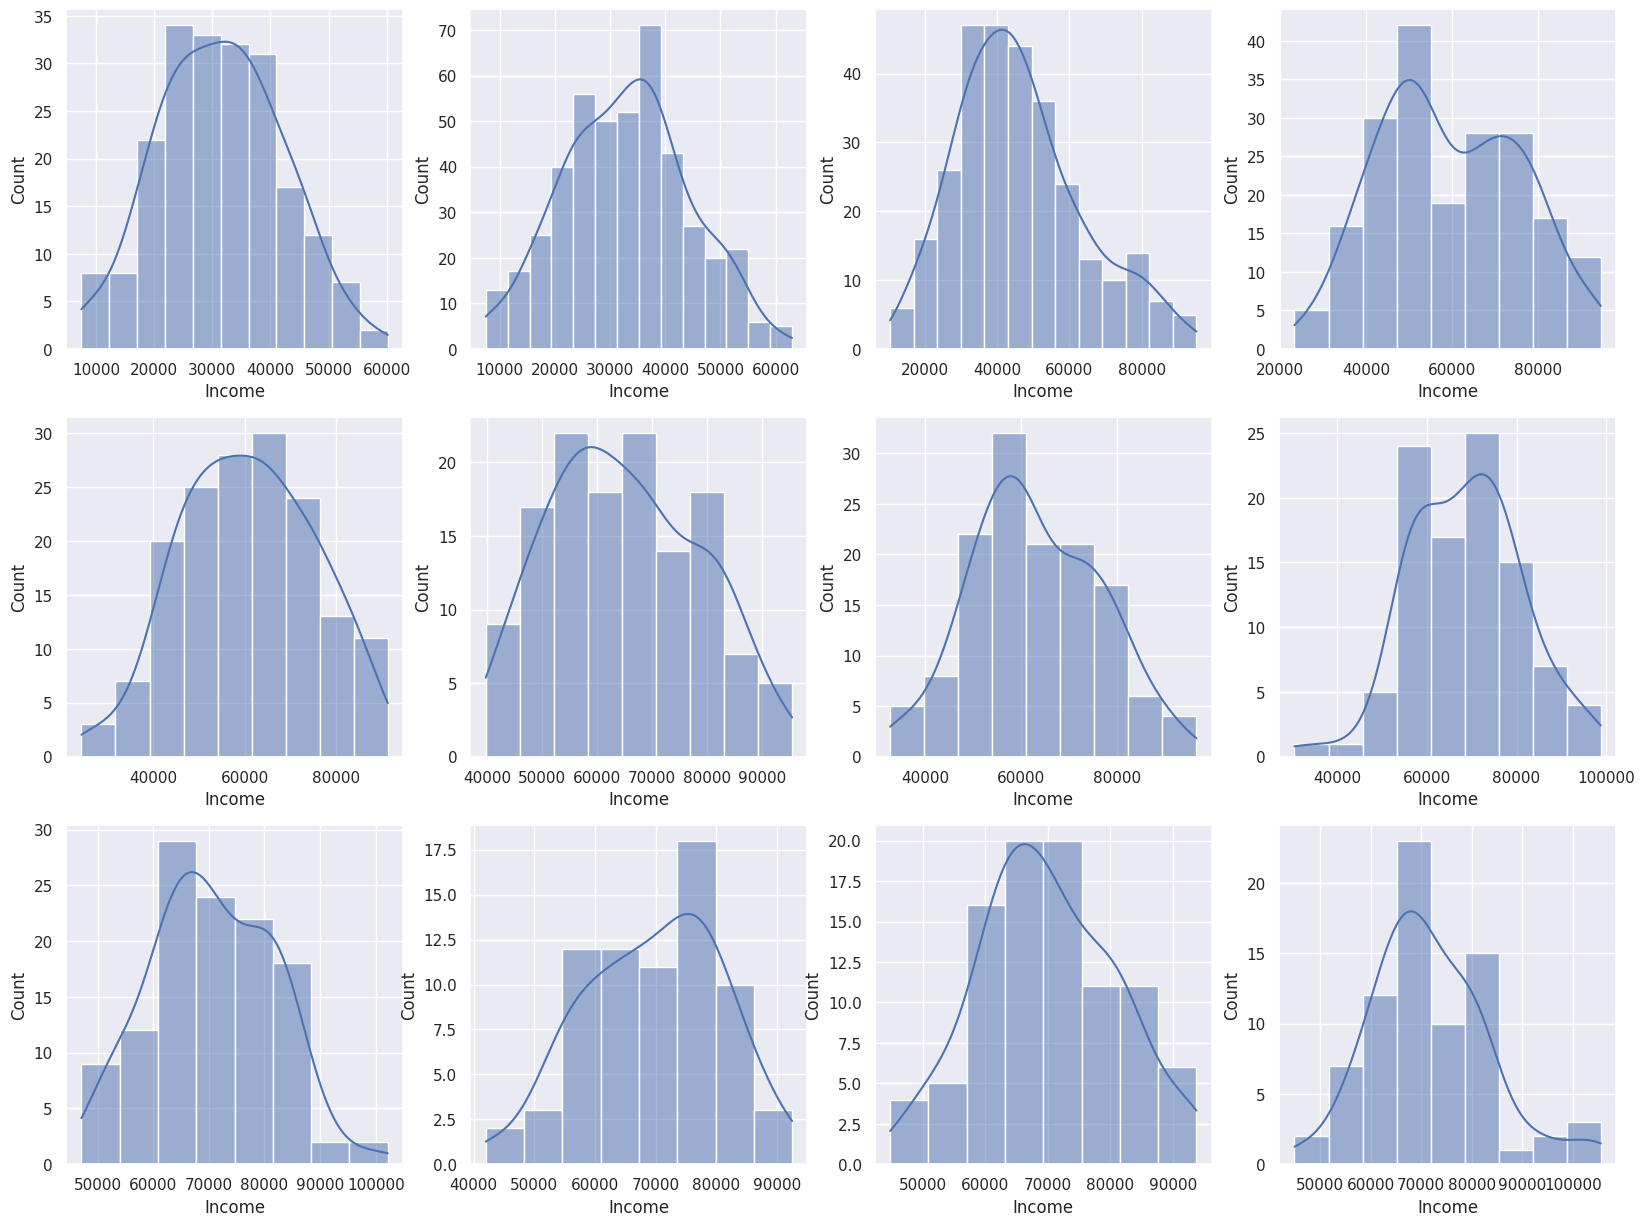

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i in range(3):
    for j in range(4):
        sns.histplot(group_by_reshape[i, j], kde=True, ax=axs[i, j])

Nous utilisons le test de Shapiro-Wilk pour vérifier la normalité des résidus du modèle linéaire OLS.  

H0 : Les résidus suivent une loi normale si p-value > 5%  
H1 : Les résidus ne suivent pas une loi normale si p-value < 5%

In [19]:
model = ols("NumStorePurchases ~ Income", data=df).fit()
shapiro(model.resid)

ShapiroResult(statistic=0.9804988503456116, pvalue=4.203593700744966e-16)

La p-value du test de Shapiro-Wilk est inférieure à 5%.  
Pour autant, le QQ plot ci-dessous nous indique que nos résidus suivent relativement bien une loi normale.

Text(0.5, 1.0, "Probability plot of model's residuals")

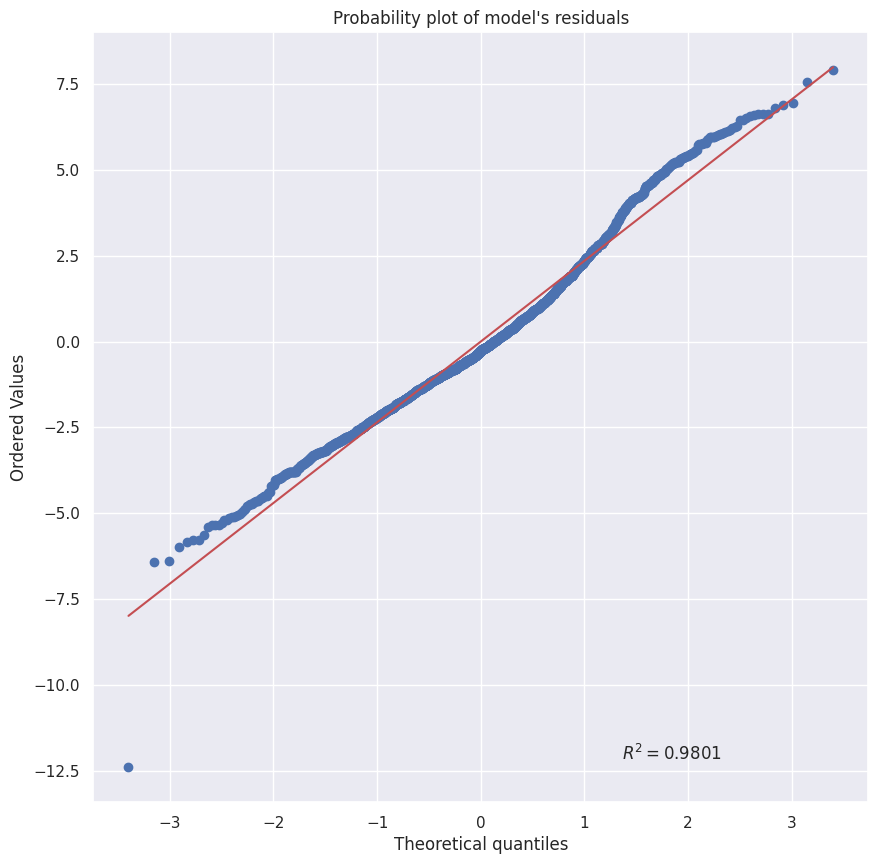

In [20]:
plt.figure(figsize=(10, 10))
stats.probplot(model.resid, plot=plt, rvalue=True)
plt.title("Probability plot of model's residuals")

## Bilan des hypothèses

| Hypothèse | Résultat | Remarque |
| :--- | :--- | :--- |
| Indépendance | ✅ | Vérifiée par la nature des données |
| Egalité des variances | ✅ | Nécessité de supprimer les groupes à 0 et 1 achat \(petit effectif\) |
| Normalité des distributions | ✅ | Test non concluant mais QQ plot concluant |


## Test d'ANOVA

H0 : Les moyennes de chaque groupe sont égales si p-value > 5%
H1 : Les moyennes de chaque groupe ne sont pas toutes égales < 5%

In [21]:
table = sm.stats.anova_lm(model)
print(table)

              df        sum_sq      mean_sq            F         PR(>F)
Income       1.0   9847.979930  9847.979930  1748.319856  1.316154e-276
Residual  2043.0  11507.861635     5.632825          NaN            NaN


Nous obtenons une p-value, pour l'hypothèse nulle "les moyennes des groupes sont égales", très proche de 0. Nous pouvons donc affirmer que le nombre d'achat en magasin dépend bien du niveau de revenu. 

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

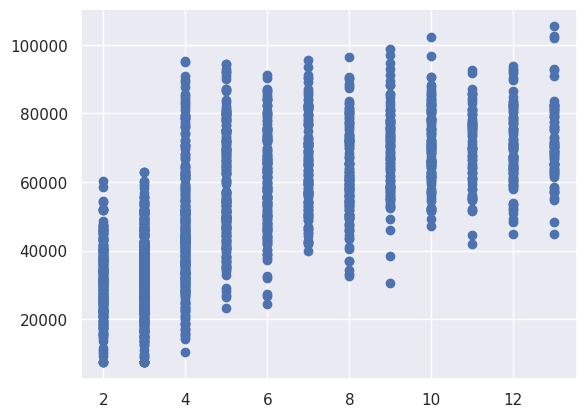

In [22]:
plt.scatter(df_anova["NumStorePurchases"], df_anova["Income"])
plt.title

In [23]:
# TODO: afficher les moyennes
# plt.scatter(df_anova["NumStorePurchases"].unique(), df_anova.groupby(by="NumStorePurchases").mean()["Income"], color="red")